# Statistics
Let's take a look at some statistics of the data we have.

In [17]:
from collections import defaultdict

import torch

from src.data.data_loading import BaseballData
from src.model.at_bat import PitchResult
from src.model.pitch_type import PitchType
from src.model.zones import ZONES_DIMENSION

import matplotlib.pyplot as plt

bd = BaseballData.load_with_cache()

Loading baseball data... done


In [30]:
locations = torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION)
pitch_types = torch.zeros(len(PitchType))
pitch_type_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_result_locations = defaultdict(lambda: torch.zeros(ZONES_DIMENSION, ZONES_DIMENSION))
pitch_results = torch.zeros(len(PitchResult))

for pitch in bd.pitches:
    for x, y in pitch.location.coords:
        locations[x, y] += 1
        pitch_type_locations[pitch.type.value][x, y] += 1
        pitch_result_locations[pitch.result.value][x, y] += 1
    pitch_types[pitch.type.value] += 1
    pitch_results[pitch.result.value] += 1

Text(0.5, 1.0, 'Pitch Locations')

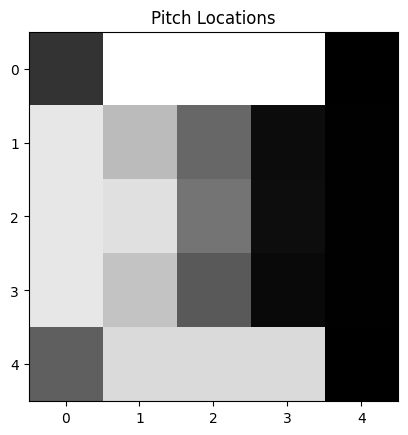

In [31]:
plt.imshow(locations, cmap='gray')
plt.title('Pitch Locations')

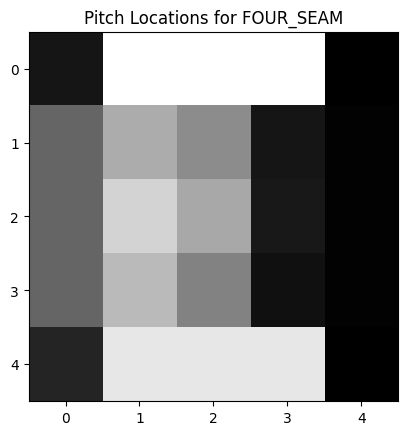

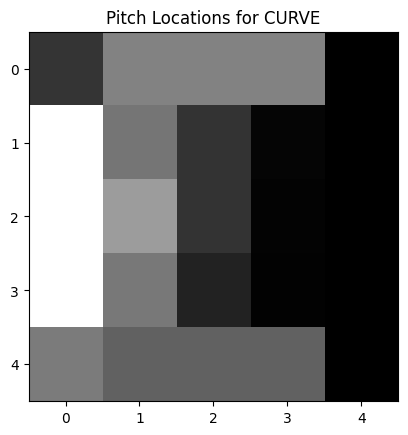

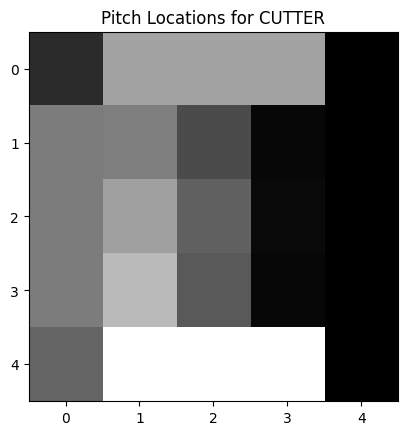

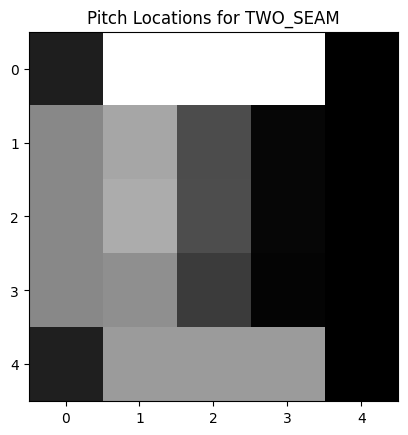

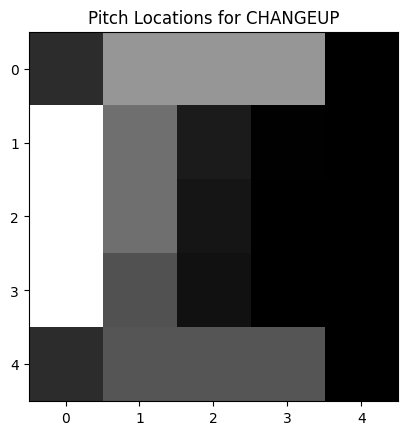

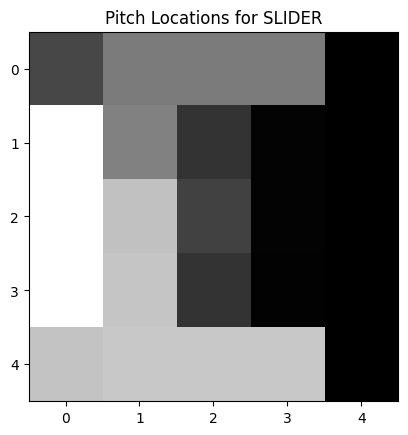

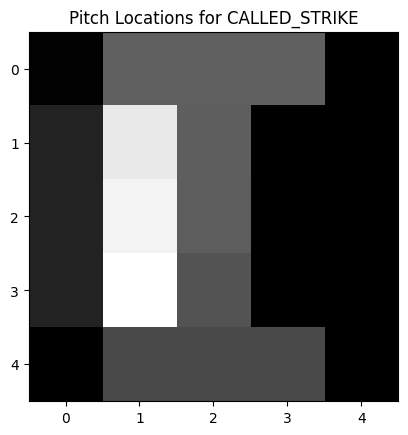

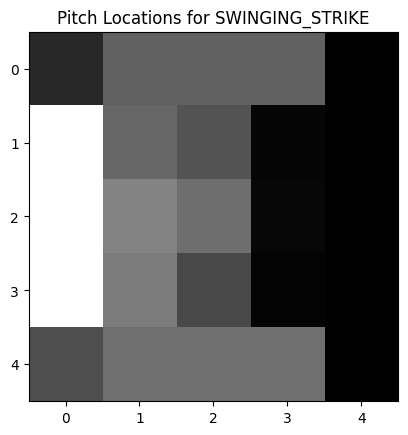

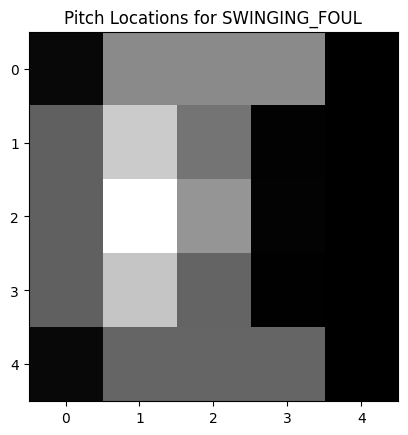

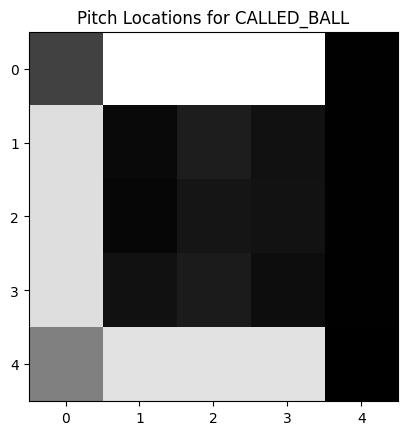

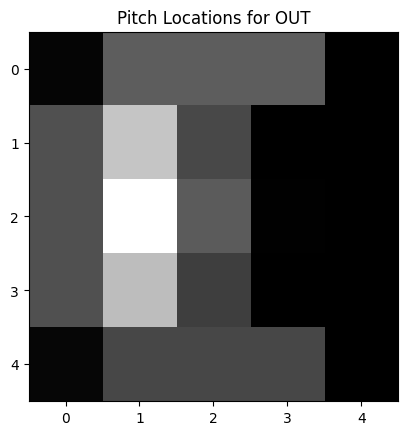

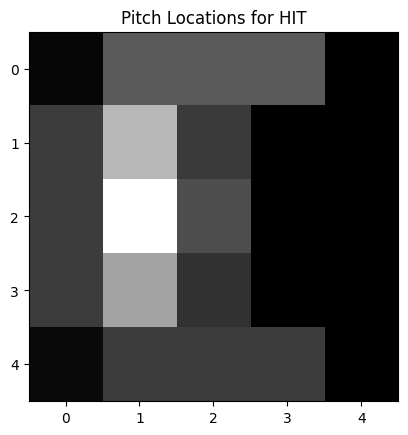

In [32]:
for pt, locs in pitch_type_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchType(pt).name}')
for pr, locs in pitch_result_locations.items():
    plt.figure()
    plt.imshow(locs, cmap='gray')
    plt.title(f'Pitch Locations for {PitchResult(pr).name}')

Text(0.5, 1.0, 'Pitch Results')

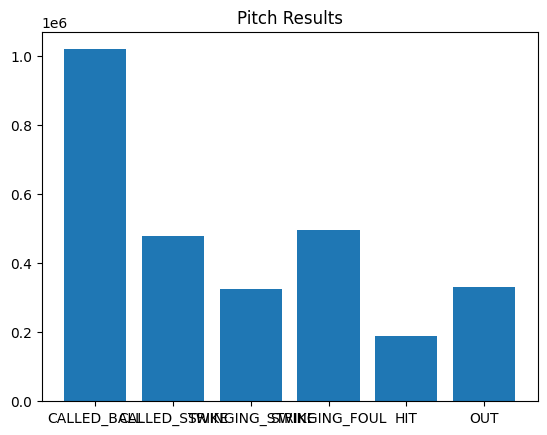

In [21]:
plt.bar([pr.name for pr in PitchResult], pitch_results)
plt.title('Pitch Results')

Text(0.5, 1.0, 'Pitch Types')

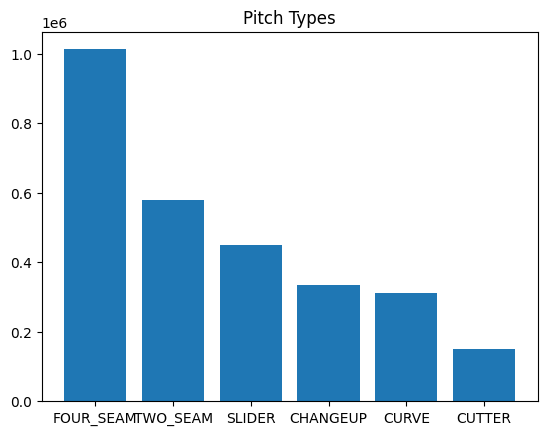

In [22]:
plt.bar([pt.name for pt in PitchType], pitch_types)
plt.title('Pitch Types')